In [1]:
!pip install split-folders

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import glob
import PIL
import pathlib
import splitfolders
import random
from tensorflow.keras import layers
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, MaxPooling2D, Flatten, BatchNormalization
from tensorflow.keras import regularizers
import tensorflow as tf
import pandas as pd
import numpy as np
import os
import time
import matplotlib.pyplot as plt
from sklearn.metrics import *
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow import keras
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.callbacks import ModelCheckpoint
import tensorflow.keras.backend as K
from tensorflow.keras.losses import CategoricalFocalCrossentropy


In [3]:
splitfolders.ratio("/kaggle/input/acne-et-rosacea/Acne_Rosacea",
                   output="/kaggle/working/dataset_split",
                   ratio=(0.7, 0.15 , 0.15))

Copying files: 1012 files [00:01, 694.86 files/s]


In [4]:
data_dir_train = pathlib.Path( '/kaggle/working/dataset_split/train')
img_height,  img_width  = 299, 299

In [5]:
train_ds = image_dataset_from_directory(data_dir_train,
                                        seed = 123,
                                        image_size=(img_height, img_width))

Found 1010 files belonging to 14 classes.


In [6]:
class_names = train_ds.class_names
class_names

['Acne',
 'Acne closed comedo',
 'Acne cystic',
 'Acne exoriated',
 'Acne infantile',
 'Acne keloidalis',
 'Acne open comedo',
 'Acne pustular',
 'Hidradenitis suppurativa',
 'Hyperhidrosis',
 'Milia',
 'Minocycline pigmentation',
 'Perioral dermatitis',
 'Rosacea']

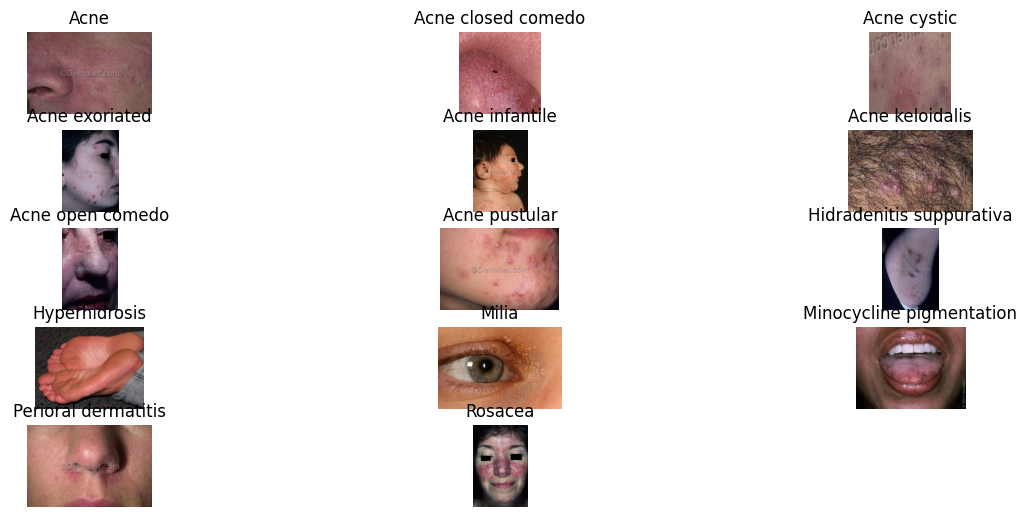

In [7]:
### Visualizing the training data
plt.figure(figsize=(15, 10))

for i, class_ in enumerate(list(class_names)):
    plt.subplot(8, 3, i+1)

    # Correct indentation for the following lines
    data_path = os.path.join(str(data_dir_train), class_)
    file_paths = glob.glob(os.path.join(data_path, '*.*'))
    random_img_path = random.choice(file_paths)
    img = PIL.Image.open(random_img_path)
    plt.imshow(img)
    plt.title(class_)
    plt.axis("off")

plt.show()

In [8]:
class_size = {}
for name in class_names:
    class_size[name] = len(list(data_dir_train.glob(name+'/*.*')))

class_size

{'Acne': 150,
 'Acne closed comedo': 150,
 'Acne cystic': 150,
 'Acne exoriated': 31,
 'Acne infantile': 18,
 'Acne keloidalis': 42,
 'Acne open comedo': 50,
 'Acne pustular': 49,
 'Hidradenitis suppurativa': 71,
 'Hyperhidrosis': 9,
 'Milia': 32,
 'Minocycline pigmentation': 15,
 'Perioral dermatitis': 80,
 'Rosacea': 163}

In [9]:
class_df = pd.DataFrame(class_size.items(),index=list(class_size), columns = ['ClassName', 'NumberOfSamples'])
class_df.drop(['ClassName'], axis = 1, inplace=True)
class_df

,NumberOfSamples
Acne,150
Acne closed comedo,150
Acne cystic,150
Acne exoriated,31
Acne infantile,18
Acne keloidalis,42
Acne open comedo,50
Acne pustular,49
Hidradenitis suppurativa,71
Hyperhidrosis,9


# **Augmentation**

In [10]:
!pip install Augmentor

In [11]:
import Augmentor

In [12]:
path_to_training_dataset = '/kaggle/working/dataset_split/train/'
target_samples = 150  # Desired number of samples per class

for i in class_names:
    class_path = os.path.join(path_to_training_dataset, i)
    existing_samples = len(os.listdir(class_path))  # Count existing images
    additional_samples = max(0, target_samples - existing_samples)  # Calculate needed samples

    if additional_samples > 0:
        p = Augmentor.Pipeline(class_path, output_directory='')

       # 1. Extreme Rotation
        p.rotate(probability=0.9, max_left_rotation=15, max_right_rotation=15)

        # 2. Horizontal & Vertical Flip
        p.flip_left_right(probability=0.8)
        p.flip_top_bottom(probability=0.5)

        # 3. Random Zoom
        p.zoom_random(probability=0.7, percentage_area=0.5)

        # 4. Random Brightness
        p.random_brightness(probability=0.8, min_factor=0.7, max_factor=1.3)

        # 5. Random Contrast
        p.random_contrast(probability=0.7, min_factor=0.7, max_factor=1.3)

        # 6. Shearing
        p.shear(probability=0.5, max_shear_left=10, max_shear_right=10)

        # 7. Skewing
        p.skew(probability=0.4, magnitude=0.2)

        # 8. Gaussian Noise
        p.gaussian_distortion(probability=0.5, grid_width=4, grid_height=4, magnitude=3, corner='bell', method='in')


        # 9. Crop & Resize (For additional variation)
        p.crop_random(probability=0.5, percentage_area=0.7)
        p.resize(probability=1.0, width=128, height=128)


      

        # Generate only the necessary number of images
        p.sample(additional_samples)

Initialised with 31 image(s) found.
Output directory set to /kaggle/working/dataset_split/train/Acne exoriated/.

Processing <PIL.Image.Image image mode=RGB size=128x128 at 0x7FF4E8051DB0>: 100%|██████████| 119/119 [00:04<00:00, 25.24 Samples/s]


Initialised with 18 image(s) found.
Output directory set to /kaggle/working/dataset_split/train/Acne infantile/.

Processing <PIL.Image.Image image mode=RGB size=128x128 at 0x7FF4E80FAB60>: 100%|██████████| 132/132 [00:05<00:00, 22.42 Samples/s]


Initialised with 42 image(s) found.
Output directory set to /kaggle/working/dataset_split/train/Acne keloidalis/.

Processing <PIL.Image.Image image mode=RGB size=128x128 at 0x7FF4E80FB910>: 100%|██████████| 108/108 [00:05<00:00, 19.02 Samples/s]


Initialised with 50 image(s) found.
Output directory set to /kaggle/working/dataset_split/train/Acne open comedo/.

Processing <PIL.Image.Image image mode=RGB size=128x128 at 0x7FF4E80FAA70>: 100%|██████████| 100/100 [00:05<00:00, 18.80 Samples/s]


Initialised with 49 image(s) found.
Output directory set to /kaggle/working/dataset_split/train/Acne pustular/.

Processing <PIL.Image.Image image mode=RGB size=128x128 at 0x7FF4CC6D91B0>: 100%|██████████| 101/101 [00:05<00:00, 17.20 Samples/s]


Initialised with 71 image(s) found.
Output directory set to /kaggle/working/dataset_split/train/Hidradenitis suppurativa/.

Processing <PIL.Image.Image image mode=RGB size=128x128 at 0x7FF4CC6D8430>: 100%|██████████| 79/79 [00:03<00:00, 20.75 Samples/s]


Initialised with 9 image(s) found.
Output directory set to /kaggle/working/dataset_split/train/Hyperhidrosis/.

Processing <PIL.Image.Image image mode=RGB size=128x128 at 0x7FF4E80BB6D0>: 100%|██████████| 141/141 [00:09<00:00, 15.41 Samples/s]


Initialised with 32 image(s) found.
Output directory set to /kaggle/working/dataset_split/train/Milia/.

Processing <PIL.Image.Image image mode=RGB size=128x128 at 0x7FF4E8030CA0>: 100%|██████████| 118/118 [00:05<00:00, 22.03 Samples/s]


Initialised with 15 image(s) found.
Output directory set to /kaggle/working/dataset_split/train/Minocycline pigmentation/.

Processing <PIL.Image.Image image mode=RGB size=128x128 at 0x7FF4E80BB880>: 100%|██████████| 135/135 [00:10<00:00, 12.72 Samples/s]


Initialised with 80 image(s) found.
Output directory set to /kaggle/working/dataset_split/train/Perioral dermatitis/.

Processing <PIL.Image.Image image mode=RGB size=128x128 at 0x7FF4E8030CD0>: 100%|██████████| 70/70 [00:03<00:00, 18.62 Samples/s]


# **Model**

In [13]:
batch_size = 8
img_size = 299

In [14]:
train_datagen = ImageDataGenerator( rescale=1./255,
                                  rotation_range=5,  # rotation
                                   width_shift_range=0.2,  # horizontal shift
                                   zoom_range=0.2,  # zoom
                                   horizontal_flip=True,
                               # horizontal flip
                                   brightness_range=[0.2,0.8])

test_datagen = ImageDataGenerator(
                                   rescale=1./255,
                                   rotation_range=5,  # rotation
                                   width_shift_range=0.2,  # horizontal shift
                                   zoom_range=0.2,  # zoom
                                   horizontal_flip=True,  # horizontal flip
                                   brightness_range=[0.2,0.8])
training_set = train_datagen.flow_from_directory('/kaggle/working/dataset_split/train',
                                               target_size=(299,299),
                                                 batch_size=8)

test_set = test_datagen.flow_from_directory('/kaggle/working/dataset_split/val',
                                            target_size=(299,299),
                                            batch_size=8,
                                            shuffle=False)

Found 2113 images belonging to 14 classes.
Found 147 images belonging to 14 classes.


In [15]:
pip install focal-loss

Note: you may need to restart the kernel to use updated packages.


In [16]:
import tensorflow as tf
from tensorflow.keras.applications import Xception
from tensorflow.keras.regularizers import l2
from tensorflow.keras.losses import CategoricalFocalCrossentropy

def Xception_finetune(weights_path):
    
    base_model = Xception(weights=None, include_top=False, input_shape=(299, 299, 3))
    
    base_model.load_weights(weights_path)

    base_model.trainable = False

    x = base_model.output
    

    # Add new classifier head
    x = tf.keras.layers.GlobalAveragePooling2D()(base_model.output)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.ReLU()(x)
    x = tf.keras.layers.Dropout(0.5)(x)
    x = layers.Dense(128, activation='relu', kernel_regularizer=l2(0.01))(x)
    x = tf.keras.layers.Dropout(0.3)(x)
    new_output = layers.Dense(14, activation='softmax', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)

    model = tf.keras.models.Model(inputs=base_model.input, outputs=new_output)
    # Use Categorical Focal Loss with alpha and gamma parameters
    focal_loss_func = CategoricalFocalCrossentropy(gamma=2.0)

    # Compile the model
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=3e-4),
        loss=focal_loss_func,
        metrics=['accuracy']
    )

    return model, base_model



In [17]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=4)
learning_rate_reduction = keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy',
                                                            patience=3,
                                                            verbose=2,
                                                            factor=0.5,
                                                            min_lr=0.00001)
reduce_lr =  keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5,
                              patience=3, min_lr=0.00001)

In [18]:
filepath = '/kaggle/working/checkpoint/acne_checkpoint.keras'
checkpoint = ModelCheckpoint(filepath , save_best_only= True, monitor = 'val_accuracy')

In [19]:
os.makedirs('/kaggle/working/Models/categories/', exist_ok=True)

In [22]:

def train():
    time_start = time.time()

    # Initialize the model
    model, base_model = Xception_finetune(
        weights_path='/kaggle/input/weights/tensorflow2/default/1/category.weights.h5'
    )
    model.summary()


    
    # Phase 1: Train only the new top layers (all base layers frozen)
    print("\nPhase 1: Training top layers only...")
    history_all = []

    history = model.fit(
        training_set,
        epochs=5,
        validation_data=test_set,
        callbacks=[early_stopping , learning_rate_reduction , reduce_lr , checkpoint]
    )
    history_all.append(history)

    # Progressive unfreezing in steps of 5 layers
    total_layers = len(model.layers)
    unfrozen = 5  # Start unfreezing from the last 5 layers
    max_unfreeze = 60  # Optional: Limit the max unfrozen layers

    phase = 2
    while unfrozen < total_layers and unfrozen <= max_unfreeze:
        print(f"\nPhase {phase}: Unfreezing last {unfrozen} layers...")

        # Unfreeze last `unfrozen` layers, avoid unfrozen BatchNorm layers
        for layer in model.layers[-unfrozen:]:
            if not isinstance(layer, tf.keras.layers.BatchNormalization):  # Freeze BatchNorm layers
                layer.trainable = True

    

     # Train again
        history = model.fit(
            training_set,
            epochs=5,
            validation_data=test_set,
            callbacks=[early_stopping, learning_rate_reduction,reduce_lr, checkpoint]
        )
        history_all.append(history)
        unfrozen += 5  # Increase the number of unfrozen layers by 15
        phase += 1

    
    model.save_weights('/kaggle/working/Models/categories/Acne_and_Rosacea.weights.h5')
    model.save('/kaggle/working/Models/categories/Acne_and_Rosacea.h5')
    
    print('Model saved.')

    time_end = time.time()
    print('Training Time:', time_end - time_start)
    
    return history


In [23]:
from tensorflow.keras.models import load_model

def test():
    #test_labels = np.array(test_labels)

    from tensorflow import keras
    print('Testing:')
    mod = keras.models.load_model('/kaggle/working/Models/categories/Acne_and_Rosacea.h5')
    mod.evaluate(test_set)

    prob = mod.predict(test_set)
    predIdxs = np.argmax(prob, axis=1)


    print('\n')
    print(classification_report(test_set.labels, predIdxs,target_names = key, digits=5))
    return  prob, predIdxs, mod

In [24]:
input_path = '/kaggle/working/dataset_split/val'
train_data = image_dataset_from_directory(directory=input_path,
                                              batch_size=8,
                                              image_size=(299, 299))

Found 147 files belonging to 14 classes.


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 299, 299, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv1 (Conv2D)     │ (None, 149, 149, 32)   │            864 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv1_bn           │ (None, 149, 149, 32)   │            128 │ block1_conv1[0][0]     │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv1_act          │ (None, 149, 149, 32)   │              0 │ block1_conv1_bn[0][0]  │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv2 (Conv2D)     │ (None, 147, 147, 64)   │         18,432 │ block1_conv1_act[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv2_bn           │ (None, 147, 147, 64)   │            256 │ block1_conv2[0][0]     │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv2_act          │ (None, 147, 147, 64)   │              0 │ block1_conv2_bn[0][0]  │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv1           │ (None, 147, 147, 128)  │          8,768 │ block1_conv2_act[0][0] │
│ (SeparableConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv1_bn        │ (None, 147, 147, 128)  │            512 │ block2_sepconv1[0][0]  │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv2_act       │ (None, 147, 147, 128)  │              0 │ block2_sepconv1_bn[0]… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv2           │ (None, 147, 147, 128)  │         17,536 │ block2_sepconv2_act[0… │
│ (SeparableConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv2_bn        │ (None, 147, 147, 128)  │            512 │ block2_sepconv2[0][0]  │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 74, 74, 128)    │          8,192 │ block1_conv2_act[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_pool               │ (None, 74, 74, 128)    │              0 │ block2_sepconv2_bn[0]… │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization  

 Total params: 21,133,750 (80.62 MB)

 Trainable params: 268,174 (1.02 MB)

 Non-trainable params: 20,865,576 (79.60 MB)


Phase 1: Training top layers only...
Epoch 1/5


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


265/265 ━━━━━━━━━━━━━━━━━━━━ 80s 236ms/step - accuracy: 0.1537 - loss: 2.9752 - val_accuracy: 0.4626 - val_loss: 2.0807 - learning_rate: 3.0000e-04
Epoch 2/5
265/265 ━━━━━━━━━━━━━━━━━━━━ 49s 181ms/step - accuracy: 0.2860 - loss: 1.9610 - val_accuracy: 0.5170 - val_loss: 1.3806 - learning_rate: 3.0000e-04
Epoch 3/5
265/265 ━━━━━━━━━━━━━━━━━━━━ 49s 179ms/step - accuracy: 0.3529 - loss: 1.3635 - val_accuracy: 0.5646 - val_loss: 0.9642 - learning_rate: 3.0000e-04
Epoch 4/5
265/265 ━━━━━━━━━━━━━━━━━━━━ 47s 175ms/step - accuracy: 0.3964 - loss: 1.0051 - val_accuracy: 0.5374 - val_loss: 0.7169 - learning_rate: 3.0000e-04
Epoch 5/5
265/265 ━━━━━━━━━━━━━━━━━━━━ 48s 176ms/step - accuracy: 0.4298 - loss: 0.7803 - val_accuracy: 0.5646 - val_loss: 0.5866 - learning_rate: 3.0000e-04

Phase 2: Unfreezing last 5 layers...
Epoch 1/5
265/265 ━━━━━━━━━━━━━━━━━━━━ 47s 173ms/step - accuracy: 0.4268 - loss: 0.6593 - val_accuracy: 0.5510 - val_loss: 0.4933 - learning_rate: 3.0000e-04
Epoch 2/5
265/265 ━━━━━━

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


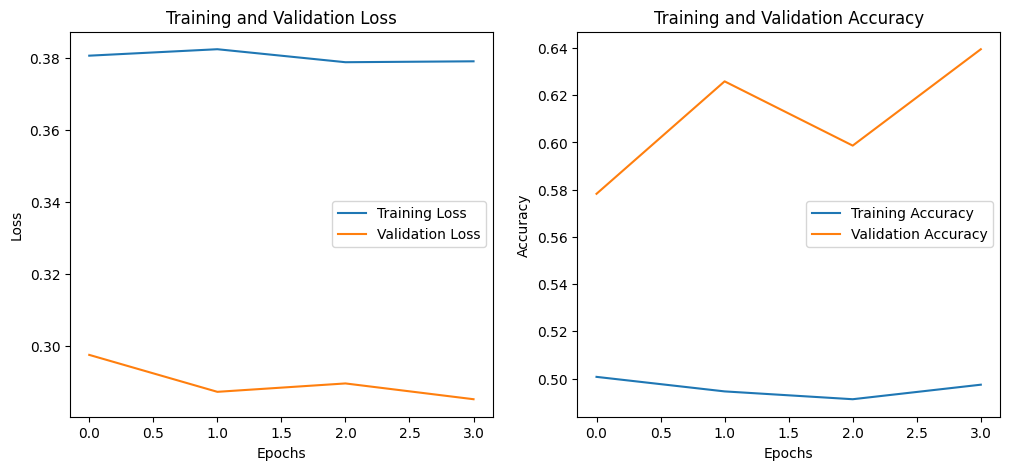

In [25]:
def plot_training_history(history):
    plt.figure(figsize=(12, 5))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()

    plt.show()

if __name__ == "__main__":
    key = train_data.class_names
    train_history = train()
    prob, predIdxs, model = test()

    # Plot training history
    plot_training_history(train_history)


In [26]:
# Define test data generator for final testing
final_test_datagen = ImageDataGenerator(rescale=1./255)

# Load final test set
final_test_set = final_test_datagen.flow_from_directory('/kaggle/working/dataset_split/test/',
                                                        target_size=(299, 299),
                                                        batch_size=8,
                                                        shuffle=False)  

# Load the model
mod = keras.models.load_model('/kaggle/working/Models/categories/Acne_and_Rosacea.h5')
 
# Evaluate the model on the final test set
final_test_loss, final_test_accuracy = mod.evaluate(final_test_set)
print(f'Final Test Loss: {final_test_loss}')
print(f'Final Test Accuracy: {final_test_accuracy}')

# Predicting and classification report
prob = model.predict(final_test_set)
predIdxs = np.argmax(prob, axis=1)

# Get class names from class indices
class_names = list(final_test_set.class_indices.keys())

# Print classification report
from sklearn.metrics import classification_report
print(classification_report(final_test_set.classes, predIdxs, target_names=class_names))

Found 164 images belonging to 14 classes.


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


21/21 ━━━━━━━━━━━━━━━━━━━━ 12s 463ms/step - accuracy: 0.4529 - loss: 0.3791
Final Test Loss: 0.30426478385925293
Final Test Accuracy: 0.5975610017776489
21/21 ━━━━━━━━━━━━━━━━━━━━ 3s 124ms/step
                          precision    recall  f1-score   support

                    Acne       0.00      0.00      0.00         7
      Acne closed comedo       0.50      0.33      0.40         6
             Acne cystic       0.67      0.64      0.65        22
          Acne exoriated       0.00      0.00      0.00         5
          Acne infantile       1.00      0.20      0.33         5
         Acne keloidalis       0.71      1.00      0.83        10
        Acne open comedo       0.50      0.33      0.40        12
           Acne pustular       0.75      0.25      0.38        12
Hidradenitis suppurativa       0.54      0.94      0.68        16
           Hyperhidrosis       1.00      0.33      0.50         3
                   Milia       0.80      0.50      0.62         8
Minocycline p

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


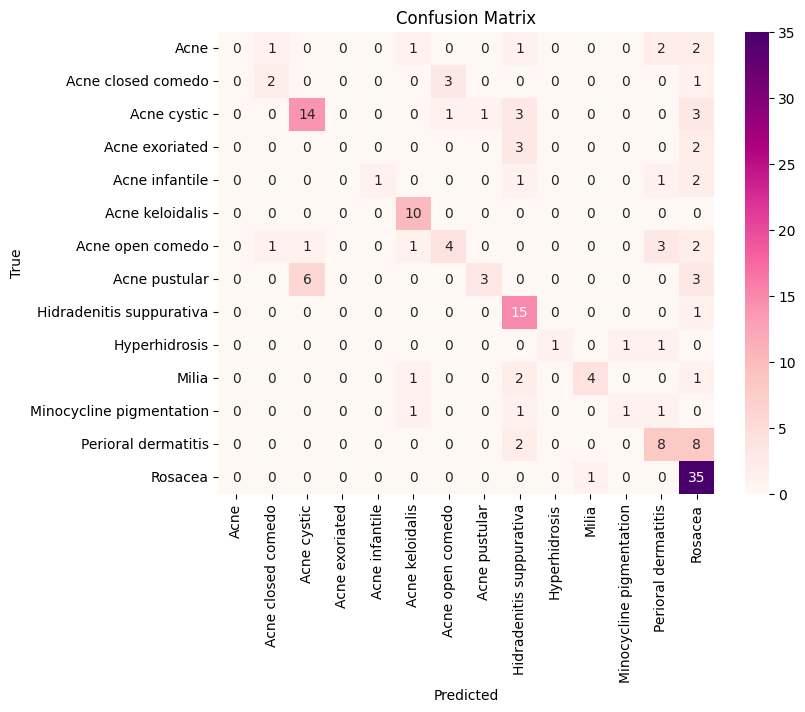

In [27]:
#Confusion Matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Generate confusion matrix
conf_matrix = confusion_matrix(final_test_set.classes, predIdxs)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='RdPu', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Example data for training and validation accuracy and loss
# Replace these with your actual data
phases = ["Phase 1", "Phase 2", "Phase 3", "Phase 4", "Phase 5", "Phase 6", "Phase 7", "Phase 8", "Phase 9"]

# Training accuracy and loss
train_accuracy = [0.1215, 0.2794, 0.3368, 0.3889, 0.4107, 0.4326, 0.4933, 0.4831, 0.4940, 0.5140, 0.5344, 0.5511, 0.5482, 0.5489, 0.5919, 0.5843, 0.5559, 0.5852, 0.5766, 0.5763, 0.6062, 0.5977, 0.6092, 0.6112, 0.6480, 0.6292, 0.6247, 0.6077, 0.6083, 0.6167, 0.6347, 0.6275, 0.6346, 0.6280, 0.6554, 0.6547, 0.6230, 0.6290, 0.6273, 0.6255, 0.6461]
train_loss = [3.2846, 2.7010, 2.3662, 2.0508, 1.8091, 1.5889, 1.3854, 1.2421, 1.1228, 0.9948, 0.8993, 0.8068, 0.7562, 0.6949, 0.6273, 0.5977, 0.5679, 0.5396, 0.5172, 0.5172, 0.4887, 0.4755, 0.4564, 0.4568, 0.4228, 0.4242, 0.4276, 0.4279, 0.4270, 0.4205, 0.4086, 0.4104, 0.4111, 0.3921, 0.3841, 0.3844, 0.3887, 0.3902, 0.3978, 0.3846, 0.3775]

# Validation accuracy and loss
val_accuracy = [0.1160, 0.2612, 0.3143, 0.3694, 0.3973, 0.4213, 0.4732, 0.4709, 0.4796, 0.4980, 0.5191, 0.5372, 0.5311, 0.5350, 0.5654, 0.5647, 0.5464, 0.5674, 0.5523, 0.5538, 0.5770, 0.5611, 0.5722, 0.5715, 0.6063, 0.5892, 0.5876, 0.5739, 0.5742, 0.5890, 0.6024, 0.5940, 0.6024, 0.5978, 0.6214, 0.6156, 0.5862, 0.5887, 0.5849, 0.5870]
val_loss = [3.4124, 2.8109, 2.4886, 2.1331, 1.9401, 1.7313, 1.5078, 1.3502, 1.2359, 1.1079, 1.0162, 0.9203, 0.8619, 0.8344, 0.7447, 0.7334, 0.6878, 0.6522, 0.6305, 0.6151, 0.5801, 0.5863, 0.5564, 0.5628, 0.5314, 0.5286, 0.5203, 0.4976, 0.5107, 0.5076, 0.5014, 0.4937, 0.4863, 0.4799, 0.4711, 0.4699, 0.4596, 0.4577, 0.4489, 0.4428]

# Create the plot
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot training accuracy on the first y-axis
ax1.plot(phases, train_accuracy[:len(phases)], color='tab:blue', label='Train Accuracy', marker='o')
ax1.set_xlabel('Phases')
ax1.set_ylabel('Accuracy', color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')

# Plot validation accuracy on the first y-axis
ax1.plot(phases, val_accuracy[:len(phases)], color='tab:green', label='Val Accuracy', marker='o')
ax1.tick_params(axis='y', labelcolor='tab:blue')

# Create a second y-axis to plot training loss and validation loss
ax2 = ax1.twinx()

# Plot training loss on the second y-axis
ax2.plot(phases, train_loss[:len(phases)], color='tab:red', label='Train Loss', marker='x')
ax2.set_ylabel('Loss', color='tab:red')
ax2.tick_params(axis='y', labelcolor='tab:red')

# Plot validation loss on the second y-axis
ax2.plot(phases, val_loss[:len(phases)], color='tab:orange', label='Val Loss', marker='x')
ax2.tick_params(axis='y', labelcolor='tab:red')

# Add title and grid
plt.title('Training and Validation Accuracy & Loss over Phases')
ax1.grid(True)

# Show plot with legends
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

# Show plot
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()



In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Extract data from the provided text
epochs = np.arange(1, 61)  # Assuming 60 epochs
accuracy =      [0.1215, 0.2794, 0.3368, 0.3889, 0.4107, 0.4326, 0.4933, 0.4831, 0.4940, 0.5140, 0.5344, 0.5511,
                 0.5482, 0.5489, 0.5919, 0.5843, 0.5559, 0.5852, 0.5766, 0.6062, 0.5977, 0.6092, 0.6112, 0.6292,
                 0.6247, 0.6077, 0.6083, 0.6167, 0.6347, 0.6275, 0.6346, 0.6280, 0.6554, 0.6230, 0.6290, 0.6273,
                 0.6255, 0.6461, 0.6243, 0.6122, 0.6023, 0.6447, 0.6225, 0.6126, 0.6333, 0.6615, 0.6058, 0.6362,
                 0.6323, 0.6274, 0.6102, 0.6365, 0.6284, 0.6259, 0.6269, 0.6311, 0.6344, 0.6190, 0.6516, 0.6481]  # Assuming 60 elements
loss =          [3.2846, 2.7010, 2.3662, 2.0508, 1.8091, 1.5889, 1.3854, 1.2421, 1.1228, 0.9948, 0.8993, 0.8068,
                 0.7562, 0.6949, 0.6273, 0.5977, 0.5679, 0.5396, 0.5172, 0.4887, 0.4755, 0.4564, 0.4568, 0.4242,
                 0.4276, 0.4279, 0.4270, 0.4205, 0.4086, 0.4104, 0.4111, 0.3921, 0.3841, 0.3959, 0.3902, 0.3978,
                 0.3846, 0.3775, 0.3887, 0.3909, 0.3928, 0.3799, 0.3860, 0.3823, 0.3827, 0.3735, 0.3838, 0.3669,
                 0.3759, 0.3676, 0.3819, 0.3654, 0.3671, 0.3742, 0.3752, 0.3735, 0.3716, 0.3647, 0.3620, 0.3638]  # Assuming 60 elements
val_accuracy = [0.4286, 0.4626, 0.4762, 0.4898, 0.5306, 0.5442, 0.5918, 0.5442, 0.6190, 0.5782, 0.6122, 0.6531,
                0.6190, 0.6463, 0.6531, 0.6667, 0.5714, 0.6259, 0.6259, 0.6667, 0.6395, 0.6259, 0.6054, 0.6190,
                0.6531, 0.6599, 0.5986, 0.6395, 0.6463, 0.6667, 0.6190, 0.6667, 0.6054, 0.6463, 0.6327, 0.6599,
                0.6531, 0.5986, 0.5986, 0.6531, 0.6463, 0.6531, 0.6667, 0.6531, 0.6395, 0.6463, 0.6463, 0.6054,
                0.6054, 0.6259, 0.6599, 0.6531, 0.6667, 0.6599, 0.6395, 0.6599, 0.6667, 0.6667, 0.6599, 0.6599] 
# Assuming 60 elements
val_loss =     [2.8020, 2.4561, 2.1394, 1.8710, 1.6121, 1.4016, 1.2326, 1.0762, 0.9689, 0.8767, 0.7868, 0.7066,
                0.6652, 0.5994, 0.5678, 0.5362, 0.5187, 0.4928, 0.4607, 0.4419, 0.4405, 0.4318, 0.4286, 0.4121,
                0.3994, 0.4038, 0.4036, 0.3926, 0.3833, 0.3792, 0.3894, 0.3813, 0.3791, 0.3735, 0.3733, 0.3731,
                0.3708, 0.3676, 0.3685, 0.3742, 0.3612, 0.3639, 0.3680, 0.3878, 0.3627, 0.3617, 0.3545, 0.3594,
                0.3487, 0.3593, 0.3556, 0.3660, 0.3517, 0.3483, 0.3415, 0.3536, 0.3592, 0.3467, 0.3470, 0.3514]  # Assuming 60 elements

# Create subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(5, 10))

# Plot accuracy
ax1.plot(epochs, accuracy, label='Training Accuracy')
ax1.plot(epochs, val_accuracy, label='Validation Accuracy')
ax1.set_title('Accuracy')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Accuracy')
ax1.legend()
ax1.grid(True)

# Plot loss
ax2.plot(epochs, loss, label='Training Loss')
ax2.plot(epochs, val_loss, label='Validation Loss')
ax2.set_title('Loss')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Loss')
ax2.legend()
ax2.grid(True)

# Adjust layout and display plot
plt.tight_layout()
plt.show()
